In [62]:
import os
import sys
while not os.getcwd().endswith('ml'):
    os.chdir('..')
sys.path.insert(0, os.getcwd())

In [63]:
import math
import copy
import cv2
import numpy as np
import random
from shutil import copyfile
from pathlib import Path
from matplotlib import pyplot as plt
from kaggle_problems.rosneft_proppant import helpers
from kaggle_problems.rosneft_proppant.helpers import *
helpers.circleContour = ColoredCircleContour()

In [64]:
DATA_DIR = "kaggle_problems/rosneft_proppant/data"
ORIGINAL_IMG_DIR = "kaggle_problems/rosneft_proppant/data/train"
DEBUG_IMG_DIR = "kaggle_problems/rosneft_proppant/data/debug"

In [65]:
def get_circle_unicolor(img, x, y, r):
    x, y = y, x
    sub_img = get_masked_img(img, x, y, r)
    if (sub_img is None):
        return None
    
    sub_img = sub_img.astype(float)
    
    msk = circleContour.get_msk(r)
    
    cnt_in_circle = np.sum(msk[:, :, 0])
    e = np.sum(sub_img, axis=(0, 1)) / cnt_in_circle
    
    sub_img -= e[np.newaxis, np.newaxis, :]
    sub_img *= msk 
    
    d = math.sqrt(np.sum(sub_img ** 2) / cnt_in_circle / 3)
    return d

def is_circle_unicolor(img, x, y, r):
    value = get_circle_unicolor(img, x, y, r)
    if value is None:
        return False
    return value < 20

In [66]:
def is_colored_circle(img, x, y, r):
    x, y = y, x
    sub_img = get_masked_img(img, x, y, r)
    if (sub_img is None):
        return False
    
    sub_img = sub_img.astype(float)
    msk = helpers.circleContour.get_msk(r)
    
    tmp = np.empty(shape=sub_img.shape)
    tmp[:, :, 0] = np.abs(sub_img[:, :, 0] - sub_img[:, :, 1])
    tmp[:, :, 1] = np.abs(sub_img[:, :, 1] - sub_img[:, :, 2])
    tmp[:, :, 2] = np.abs(sub_img[:, :, 2] - sub_img[:, :, 0])
    
    sub_img = tmp
    
    cnt_in_circle = np.sum(msk)
    
    e = np.sum(sub_img) / cnt_in_circle
    
    sub_img -= e
    sub_img *= msk 
    
    d = np.sum(sub_img ** 2) / cnt_in_circle
    #sreturn d
    return d > 3000
    
    

In [67]:
def get_brith_circle(img, hsv_img, x, y, r):
    x, y = y, x
    hsv_sub_img = get_masked_img(hsv_img, x, y, r)
    if (hsv_sub_img is None):
        return False
    
    hsv_sub_img = hsv_sub_img.astype(float)
    msk = circleContour.get_msk(r)
    
    mean = np.sum(hsv_sub_img[:, :, 1]) / np.sum(msk)
    return mean
    
def is_brith_circle(img, hsv_img, x, y, r): # Яркость
    return get_brith_circle(img, hsv_img, x, y, r) > 70


In [68]:
def process_color_img(original_img, img_number):
    result_circles = []
    debug_dir = "{}/{}".format(DEBUG_IMG_DIR, img_number)
    
    Path(debug_dir).mkdir(exist_ok=True, parents=True) # create debug dir
    
    img_with_circle = copy.deepcopy(original_img)
    img = copy.deepcopy(original_img)
    
    gaussian_3 = cv2.GaussianBlur(img, (3, 3), 20.0)
    img = cv2.addWeighted(img, 1.5, gaussian_3, -0.5, 0, img)
    
    hsv_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2HSV)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    cv2.imwrite("{}/original_img.jpg".format(debug_dir), original_img)
    cv2.imwrite("{}/img.jpg".format(debug_dir), img)
    cv2.imwrite("{}/gray.jpg".format(debug_dir), gray)

    
    
    it = 0
    for r in range(6, 1, -1):
        print('-' * 30)
        # Выделение кругов
        circles = cv2.HoughCircles(gray,cv2.HOUGH_GRADIENT,0.5,minDist=r,
                                param1=200,param2=1,minRadius=r,maxRadius=r)
        circles = circles[0]
        print("Circle count: {}. r: {}".format(len(circles), r))
        filtered_circle = [(int(circle[0]), int(circle[1]), int(circle[2])) for circle in circles]

        
        filtered_circle = [circle for circle in filtered_circle if is_brith_circle(img, hsv_img, circle[0], circle[1], circle[2])]
        print("After first filter: {}. r: {}".format(len(filtered_circle), r))
        
        tmp = [get_circle_unicolor(img, circle[0], circle[1], circle[2]) for circle in filtered_circle]
        plt.hist(tmp, bins=256)
        plt.show()

        filtered_circle = [circle for circle in filtered_circle if is_circle_unicolor(img, circle[0], circle[1], circle[2])]
        print("After second filter: {}. r: {}".format(len(filtered_circle), r))
        
        for circle in filtered_circle:
            cv2.circle(img,(circle[0],circle[1]),circle[2],(255, 255, 255),-1)
            cv2.circle(img_with_circle,(circle[0],circle[1]),circle[2], (0, 255, 0),1)

        cv2.imwrite("{}/img_{}.jpg".format(debug_dir, it), img)
        cv2.imwrite("{}/img_with_circle_{}.jpg".format(debug_dir, it), img_with_circle)
        cv2.imwrite("{}/hsv_img_{}.jpg".format(debug_dir, it), hsv_img[:, :, 1])
        
        it += 1
        result_circles.extend(filtered_circle)
        
    return result_circles



------------------------------
Circle count: 25570. r: 6
After first filter: 9546. r: 6


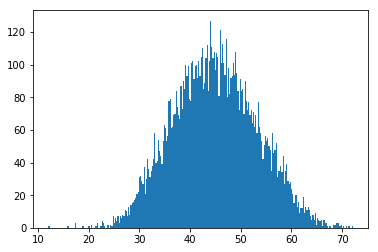

After second filter: 8. r: 6
------------------------------
Circle count: 37126. r: 5
After first filter: 14274. r: 5


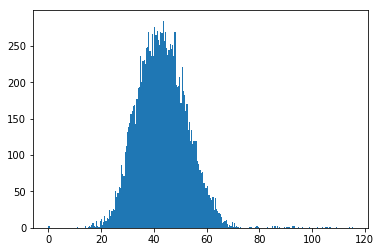

After second filter: 54. r: 5
------------------------------
Circle count: 51855. r: 4
After first filter: 20252. r: 4


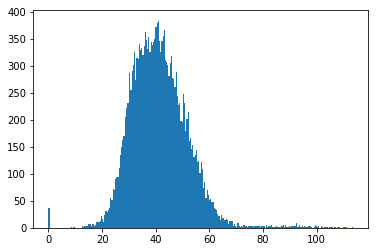

After second filter: 162. r: 4
------------------------------
Circle count: 80128. r: 3
After first filter: 32619. r: 3


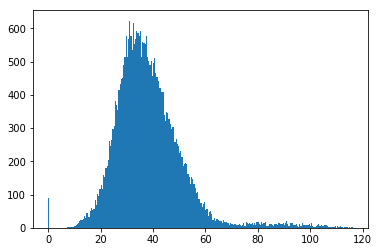

After second filter: 1107. r: 3
------------------------------
Circle count: 152837. r: 2
After first filter: 63064. r: 2


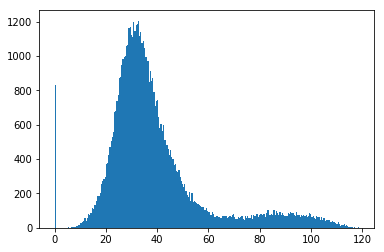

After second filter: 3782. r: 2


[(452, 724, 7),
 (516, 719, 7),
 (382, 1456, 7),
 (1023, 775, 6),
 (416, 1461, 7),
 (40, 1271, 7),
 (1014, 1036, 7),
 (181, 1177, 7),
 (977, 500, 6),
 (1023, 775, 6),
 (729, 205, 6),
 (971, 721, 5),
 (1033, 787, 5),
 (291, 560, 6),
 (880, 828, 6),
 (41, 695, 5),
 (929, 1088, 5),
 (241, 888, 5),
 (280, 472, 5),
 (943, 431, 5),
 (972, 1009, 5),
 (45, 1248, 5),
 (805, 210, 5),
 (18, 1348, 5),
 (331, 762, 5),
 (66, 1184, 6),
 (557, 577, 6),
 (486, 1170, 5),
 (731, 1126, 5),
 (896, 1366, 5),
 (932, 1030, 5),
 (1017, 1117, 5),
 (1036, 1348, 5),
 (1054, 763, 5),
 (1040, 1075, 6),
 (943, 522, 5),
 (793, 1346, 6),
 (66, 1119, 5),
 (142, 1233, 5),
 (337, 1461, 5),
 (910, 1404, 5),
 (788, 1270, 5),
 (913, 1113, 5),
 (451, 724, 6),
 (73, 922, 5),
 (334, 828, 5),
 (500, 1384, 5),
 (721, 125, 5),
 (978, 1030, 5),
 (156, 1357, 6),
 (321, 1202, 6),
 (802, 1356, 6),
 (813, 894, 6),
 (980, 1459, 6),
 (497, 589, 5),
 (597, 1029, 5),
 (40, 1271, 6),
 (979, 1137, 6),
 (757, 890, 5),
 (806, 896, 5),
 (988, 

In [69]:
img_name = "11"
original_img = cv2.imread("{}/tmp/{}".format(DATA_DIR, img_name + ".png")) 

process_color_img(original_img, img_name)

In [ ]:
11 & 51

In [61]:
original_img = cv2.imread("{}/tmp/{}".format(DATA_DIR, img_name + ".png")) 
original_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2HSV)
original_img[:, :, 0] = 255
original_img = cv2.cvtColor(original_img, cv2.COLOR_HSV2RGB)

cv2.imwrite("img.png", original_img)

True

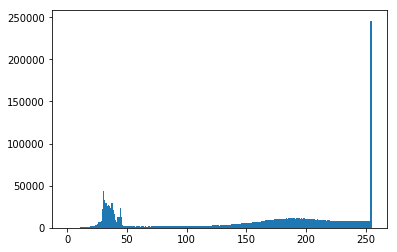

In [39]:
v = np.reshape(original_img[:, :, 1], (original_img.shape[0] * original_img.shape[1]))
plt.hist(v, bins=range(0, 256))
plt.show()

In [ ]:
#H: 0 - 180, S: 0 - 255, V: 0 - 255